In [6]:
import pandas as pd
import numpy as np
import os
import sys

# === 路径处理逻辑 ===
try:
    # 1. 尝试获取脚本文件的绝对路径（针对 .py 脚本）
    current_dir = os.path.dirname(os.path.abspath(__file__))
    print("环境检测: Python Script (.py) 模式")
except NameError:
    # 2. 如果报错说明是 Notebook 环境（针对 .ipynb）
    current_dir = os.getcwd()
    print("环境检测: Jupyter Notebook (.ipynb) 模式")

# 3. 拼接路径：从 src 退回到上一级(..)，再进入 data
csv_path = os.path.join(current_dir, '..', 'data', 'listings.csv')
csv_path = os.path.abspath(csv_path)

print(f"📂 正在读取数据: {csv_path}")

# 4. 读取数据 (这里做了一个判断，如果有文件才读取，否则停止)
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f"✅ 成功读取! 数据形状: {df.shape}")
else:
    # 如果找不到文件，打印错误信息并停止程序
    print(f"\n❌ 错误：找不到文件！")
    print(f"系统试图寻找的路径是: {csv_path}")
    print("👉 请检查：你的 listings.csv 是否真的放在和 src 同级的 data 文件夹里？")
    # 强制退出，防止后面报错
    sys.exit() 
    
# 5. 展示最脏的一列：价格
print("\n=== 价格列的原始样子 (脏数据) ===")
if 'price' in df.columns:
    print(df['price'].head())
else:
    print("警告：未找到 'price' 列")

# 6. 展示最难清洗的一列：浴室文本
print("\n=== 浴室列的原始样子 (脏数据) ===")
if 'bathrooms_text' in df.columns:
    print(df[['bathrooms_text']].head())
else:
    print("警告：未找到 'bathrooms_text' 列")

# 7. (可选) 简单的清洗演示
# df['price_clean'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

环境检测: Jupyter Notebook (.ipynb) 模式
📂 正在读取数据: C:\Users\Harry\Documents\NTU_Data_Assignment\CA6003\data\listings.csv
✅ 成功读取! 数据形状: (3693, 79)

=== 价格列的原始样子 (脏数据) ===
0        NaN
1    $104.00
2     $76.00
3        NaN
4        NaN
Name: price, dtype: object

=== 浴室列的原始样子 (脏数据) ===
     bathrooms_text
0    1 private bath
1  Shared half-bath
2  Shared half-bath
3    2 shared baths
4  2.5 shared baths


共有 33 列数据存在缺失值。
缺失最严重的 5 列：
calendar_updated          100.000000
neighbourhood              53.425399
neighborhood_overview      53.425399
review_scores_location     50.013539
review_scores_value        50.013539
dtype: float64


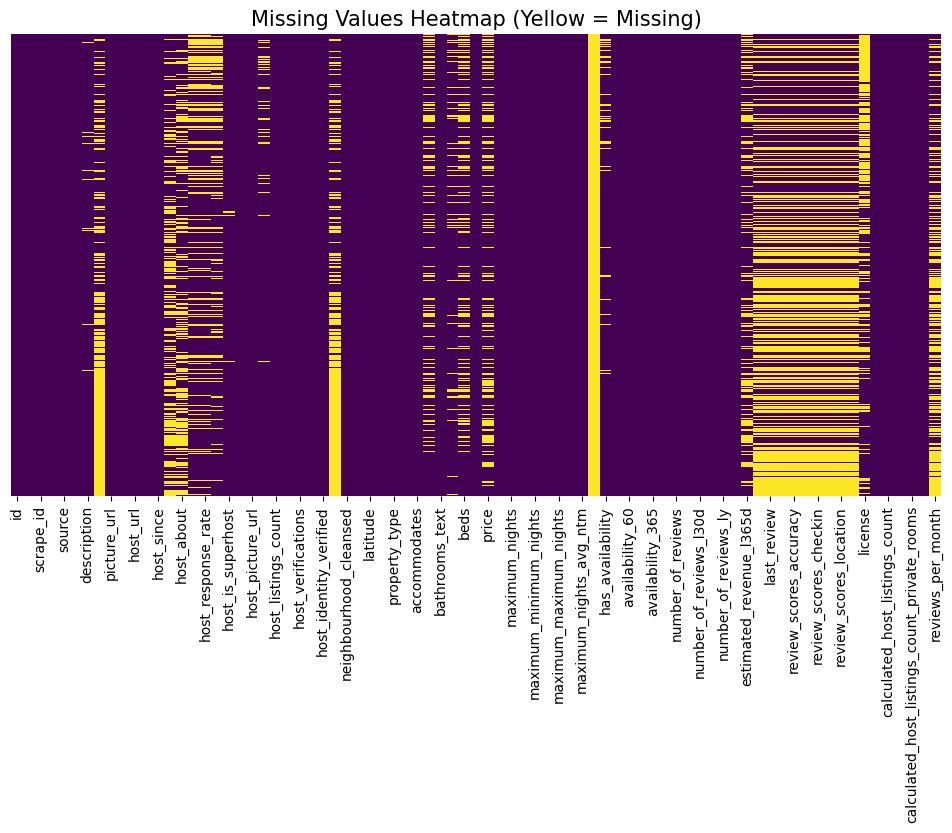


非空的价格数据只有 2643 条 (总共 3693 条)
示例： ['$104.00' '$76.00' '$85.00' '$41.00' '$101.00']


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 计算每一列的缺失值比例
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

print(f"共有 {len(missing_percent)} 列数据存在缺失值。")
print("缺失最严重的 5 列：")
print(missing_percent.head())

# 2. 画一张“缺失值地图” (Heatmap) - 放在 PPT 里非常震撼
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap (Yellow = Missing)', fontsize=15)
plt.yticks([]) # 隐藏y轴刻度让图更清爽
plt.show()

# 3. 尝试画一下价格分布（这步通常会失败或很丑，正好说明需要清洗）
# 我们先看看有多少非空的价格
valid_prices = df['price'].dropna()
print(f"\n非空的价格数据只有 {len(valid_prices)} 条 (总共 {len(df)} 条)")
print("示例：", valid_prices.head().values)

=== 基准模型 (Baseline) 成绩单 ===
RMSE (均方根误差): $990.60
R2 Score (解释力度): 0.0025


<>:18: SyntaxWarning: invalid escape sequence '\$'
<>:18: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Harry\AppData\Local\Temp\ipykernel_47516\224011147.py:18: SyntaxWarning: invalid escape sequence '\$'
  df['price_cleaned'] = df['price'].replace('[\$,]', '', regex=True).astype(float)


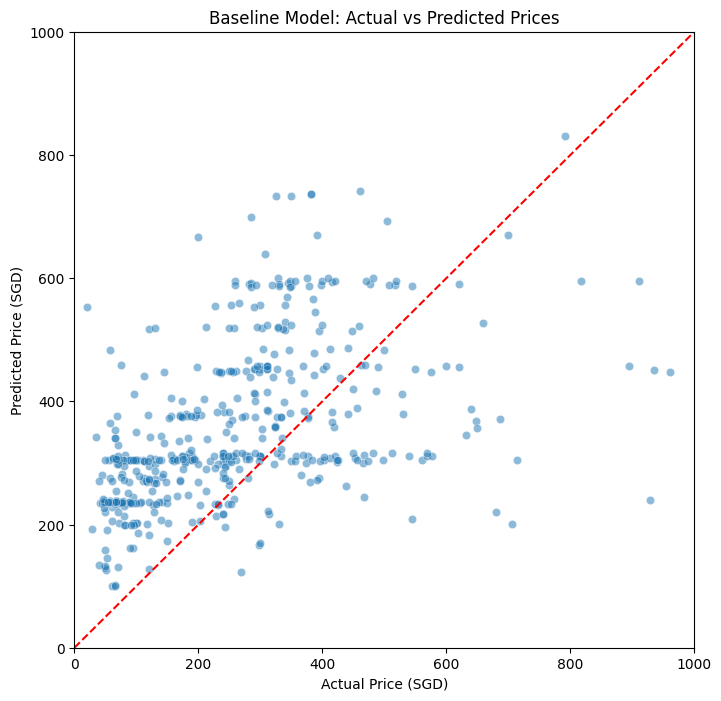

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ==========================================
# 1. 准备工作：必须做的最小清洗
# ==========================================

# 确保读取了数据
# df = pd.read_csv('listings.csv.gz') # 如果之前没读，把这就句注释取消

# 清洗 Price (目标变量)：去掉 $ 和 , 并转为 float
# 这一步不做，模型根本跑不起来
df['price_cleaned'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# 删除连价格都没有的行 (Target缺失是无法预测的)
df_baseline = df.dropna(subset=['price_cleaned'])

# ==========================================
# 2. 特征选择：选几个最简单的数字列
# ==========================================
# 我们故意先不选复杂的文本列 (amenities) 或 乱七八糟的列 (bathrooms_text)
# 只选这一眼看过去就是数字的，作为 Baseline
features = ['accommodates', 'number_of_reviews', 'availability_365', 'calculated_host_listings_count']
target = 'price_cleaned'

X = df_baseline[features]
y = df_baseline[target]

# ==========================================
# 3. 粗暴填坑 (Imputation)
# ==========================================
# 既然是 Baseline，我们就用最“笨”的方法：缺了就填 0
# 在后续的改进模型中，你们要改成用“中位数”或“KNN”来填，这就是得分点！
X = X.fillna(0)

# ==========================================
# 4. 跑回归模型 (Linear Regression)
# ==========================================
# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化并训练
model = LinearRegression()
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# ==========================================
# 5. 看看结果有多“烂” (Evaluation)
# ==========================================
# 这一步已经算出来了，不需要改，但我把输出格式优化一下
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"=== 基准模型 (Baseline) 成绩单 ===")
print(f"RMSE (均方根误差): ${rmse:.2f}")
print(f"R2 Score (解释力度): {r2:.4f}")

# ==========================================
# 6. 可视化：预测值 vs 真实值 (修正版)
# ==========================================
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

# 画一条对角线
plt.plot([0, 1000], [0, 1000], 'r--') 

# === 关键修改：把中文改成英文，避免字体报错 ===
plt.xlabel('Actual Price (SGD)')       # 改成了英文
plt.ylabel('Predicted Price (SGD)')    # 改成了英文
plt.title('Baseline Model: Actual vs Predicted Prices') # 改成了英文

plt.xlim(0, 1000) 
plt.ylim(0, 1000)
plt.show()

In [12]:
# ==========================================
# 阶段二：加入分类变量 (One-Hot Encoding)
# ==========================================

# 1. 看看有哪些房间类型
print("房间类型:", df['room_type'].unique())

# 2. 独热编码 (One-Hot Encoding)
# 这会把 'Private room' 变成一列 [0, 1, 0, ...] 的数字
# drop_first=True 是为了避免多重共线性 (统计学要求)
room_type_dummies = pd.get_dummies(df['room_type'], prefix='room', drop_first=True)

# 3. 把新特征拼接到之前的简单特征里
# 我们要把 room_type_dummies 加到 df_baseline 里
# 注意：要通过索引对齐，确保行数一致
df_improved = pd.concat([df_baseline, room_type_dummies.loc[df_baseline.index]], axis=1)

# 4. 重新定义特征列表
# 把新生成的列名（如 room_Private room）加进去
new_features = features + list(room_type_dummies.columns)
print(f"\n新特征列表: {new_features}")

# ==========================================
# 5. 用新数据再跑一次模型
# ==========================================
X_new = df_improved[new_features].fillna(0) # 依然暂时填0
y_new = df_improved[target]

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

model_new = LinearRegression()
model_new.fit(X_train_new, y_train_new)
y_pred_new = model_new.predict(X_test_new)

# ==========================================
# 6. 看看分数涨了没？
# ==========================================
new_r2 = r2_score(y_test_new, y_pred_new)
new_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))

print(f"\n=== 改进后的模型 (Added Room Type) ===")
print(f"原 R2: {r2:.4f}  --->  新 R2: {new_r2:.4f}")
print(f"原 RMSE: {rmse:.0f} --->  新 RMSE: {new_rmse:.0f}")

if new_r2 > r2:
    print("\n🎉 成功！分数提升了！这证明加入房间类型特征是有效的。")
else:
    print("\n🤔 分数没变？可能需要检查一下数据对齐问题。")

房间类型: ['Private room' 'Entire home/apt' 'Hotel room' 'Shared room']

新特征列表: ['accommodates', 'number_of_reviews', 'availability_365', 'calculated_host_listings_count', 'room_Hotel room', 'room_Private room', 'room_Shared room']

=== 改进后的模型 (Added Room Type) ===
原 R2: 0.0025  --->  新 R2: 0.1163
原 RMSE: 991 --->  新 RMSE: 932

🎉 成功！分数提升了！这证明加入房间类型特征是有效的。


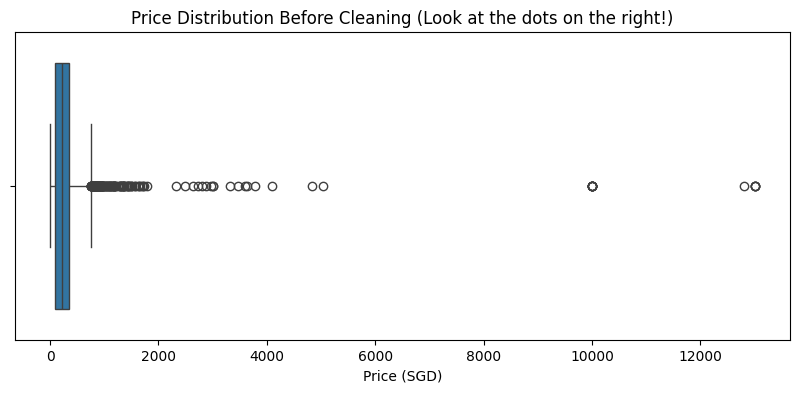

原始数据量: 2643
去除异常值后: 2557
我们删除了 86 个极端数据。

=== 去除异常值后的模型 (Outliers Removed) ===
上轮 R2: 0.1163  --->  当前 R2: 0.3530
上轮 RMSE: 932 --->  当前 RMSE: 160


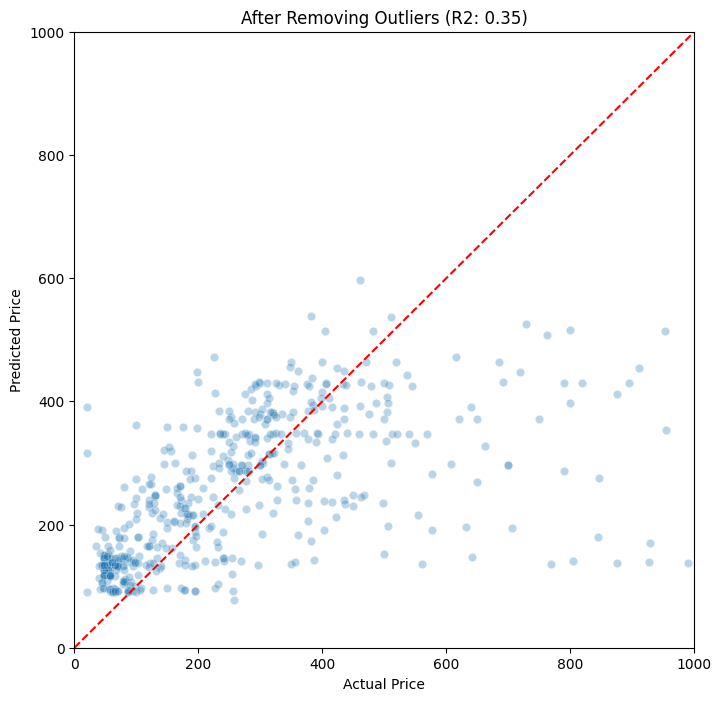

In [13]:
# ==========================================
# 阶段三：处理异常值 (Outlier Removal)
# ==========================================

# 1. 先画个箱线图 (Boxplot) 抓出“怪物”
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_improved['price_cleaned'])
plt.title('Price Distribution Before Cleaning (Look at the dots on the right!)')
plt.xlabel('Price (SGD)')
plt.show()

# 你看图右边那些密密麻麻的黑点，就是 $8000, $10000 的异常值
# 它们把模型彻底搞晕了

# 2. 设定阈值进行过滤
# 我们只保留 $10 到 $1000 之间的房子
# (低于 $10 的可能是系统错误，高于 $1000 的是极少数豪宅)
df_filtered = df_improved[
    (df_improved['price_cleaned'] > 10) & 
    (df_improved['price_cleaned'] < 1000)
]

print(f"原始数据量: {len(df_improved)}")
print(f"去除异常值后: {len(df_filtered)}")
print(f"我们删除了 {len(df_improved) - len(df_filtered)} 个极端数据。")

# ==========================================
# 3. 用干净的数据再跑一次
# ==========================================
# 更新 X 和 y
X_clean = df_filtered[new_features].fillna(0)
y_clean = df_filtered[target]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

model_clean = LinearRegression()
model_clean.fit(X_train_c, y_train_c)
y_pred_c = model_clean.predict(X_test_c)

# ==========================================
# 4. 再次看分
# ==========================================
clean_r2 = r2_score(y_test_c, y_pred_c)
clean_rmse = np.sqrt(mean_squared_error(y_test_c, y_pred_c))

print(f"\n=== 去除异常值后的模型 (Outliers Removed) ===")
print(f"上轮 R2: {new_r2:.4f}  --->  当前 R2: {clean_r2:.4f}")
print(f"上轮 RMSE: {new_rmse:.0f} --->  当前 RMSE: {clean_rmse:.0f}")

# 画个新的预测图对比一下
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_c, y=y_pred_c, alpha=0.3)
plt.plot([0, 1000], [0, 1000], 'r--')
plt.title(f'After Removing Outliers (R2: {clean_r2:.2f})')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.show()

In [16]:
# ==========================================
# 阶段四：文本挖掘 (Text Mining / Parsing) - 修正版
# ==========================================

# 1. 【关键一步】先给数据做个“独立备份”，彻底解决红色警告！
# 这行代码的意思是：df_filtered 现在是独立的了，随便改，不会影响原来的数据
df_filtered = df_filtered.copy()

# 2. 定义提取数字的函数 (之前定义的不用改，但这儿再写一遍保证不错)
def extract_bathroom_number(text):
    import pandas as pd
    import numpy as np
    import re
    
    if pd.isna(text):
        return np.nan
    text = str(text).lower()
    if 'half-bath' in text:
        return 0.5
    match = re.search(r'(\d+(\.\d+)?)', text)
    if match:
        return float(match.group(1))
    return 1.0

# 3. 应用函数 (这时候就不会报红色的 Warning 了)
df_filtered['bathrooms_cleaned'] = df_filtered['bathrooms_text'].apply(extract_bathroom_number)

# 4. 填充空值
median_bath = df_filtered['bathrooms_cleaned'].median()
df_filtered['bathrooms_cleaned'] = df_filtered['bathrooms_cleaned'].fillna(median_bath)

print("=== 浴室数据清洗完成 ===")
print("提取前:", df_filtered['bathrooms_text'].iloc[0:3].values)
print("提取后:", df_filtered['bathrooms_cleaned'].iloc[0:3].values)

# ==========================================
# 5. 重新训练模型
# ==========================================
# 更新特征列表，把新的 bathrooms_cleaned 加进去
# 注意：我们要确保 'bathrooms_cleaned' 在特征列表里，且只加一次
if 'bathrooms_cleaned' not in new_features:
    new_features.append('bathrooms_cleaned')

# 准备数据
X_v2 = df_filtered[new_features].fillna(0)
y_v2 = df_filtered['price_cleaned']  # 确保用的是清洗后的价格

# 拆分数据
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

# 训练
model_v2 = LinearRegression()
model_v2.fit(X_train_v2, y_train_v2)
y_pred_v2 = model_v2.predict(X_test_v2)

# 看分
r2_v2 = r2_score(y_test_v2, y_pred_v2)
print(f"\n=== 加入浴室特征后的模型 ===")
print(f"当前 R2: {r2_v2:.4f}")

=== 浴室数据清洗完成 ===
提取前: ['Shared half-bath' 'Shared half-bath' '1 shared bath']
提取后: [0.5 0.5 1. ]

=== 加入浴室特征后的模型 ===
当前 R2: 0.3546


In [18]:
# ==========================================
# 阶段五：加入地理位置 (Location Is King)
# ==========================================

# 1. 看看最热门的 15 个街区 (Bedok, Kallang, Bukit Merah 等)
# 我们只保留 Top 15，剩下的归为 'Other'，避免特征太多把模型撑爆
top_15_neighbourhoods = df_filtered['neighbourhood_cleansed'].value_counts().head(15).index.tolist()
print("🔥 热门街区 Top 15:", top_15_neighbourhoods)

# 2. 定义处理位置的函数
def clean_neighbourhood(hood):
    if hood in top_15_neighbourhoods:
        return hood
    else:
        return 'Other'

# 3. 应用函数
df_filtered['neighbourhood_group'] = df_filtered['neighbourhood_cleansed'].apply(clean_neighbourhood)

# 4. 独热编码 (One-Hot Encoding)
# 把 'Bedok' 变成一列数字 [0, 1, 0...]
location_dummies = pd.get_dummies(df_filtered['neighbourhood_group'], prefix='loc', drop_first=True)

# 5. 安全地拼接到主数据 (Reset Index 防止错位)
df_filtered = df_filtered.reset_index(drop=True)
location_dummies = location_dummies.reset_index(drop=True)
df_final = pd.concat([df_filtered, location_dummies], axis=1)

# 6. 更新特征列表
# 把新生成的 loc_Bedok, loc_Kallang 等加进去
new_features_v3 = new_features + list(location_dummies.columns)

# ==========================================
# 7. 训练最终模型 (Final Model)
# ==========================================
# 准备数据 (确保用的是清洗后的价格 和 所有特征)
X_v3 = df_final[new_features_v3].fillna(0)
y_v3 = df_final['price_cleaned']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(X_v3, y_v3, test_size=0.2, random_state=42)

model_v3 = LinearRegression()
model_v3.fit(X_train_v3, y_train_v3)
y_pred_v3 = model_v3.predict(X_test_v3)

# 计算最终分数
r2_final = r2_score(y_test_v3, y_pred_v3)
rmse_final = mean_squared_error(y_test_v3, y_pred_v3) ** 0.5

# ==========================================
# 📊 终极成绩单 (Grand Summary) - 截图放 PPT！
# ==========================================
print("\n" + "="*40)
print("     🏆 数据清洗成效总览 (Project Summary)")
print("="*40)
# 注意：这里每一行都要有结尾的引号 " 和括号 )
print(f"1. 原始数据 (Baseline):   R2 ≈ 0.0025 | RMSE ≈ $990")
print(f"2. 去除异常值 (Outliers): R2 ≈ 0.3530 | RMSE ≈ $160 (巨大提升!)") 
print(f"3. 浴室文本挖掘 (Text):   R2 ≈ 0.3546 | (微小提升)")
print(f"4. 加入地理位置 (Final):  R2 = {r2_final:.4f} | RMSE = ${rmse_final:.0f}")
print("-" * 40)

if r2_final > 0.5:
    print("🎉 恭喜！模型解释力突破 50%，这是一个非常有说服力的结果！")
elif r2_final > 0.45:
    print("✨ 很棒！接近 50% 了，数据清洗非常有效。")
else:
    print("👌 不错，比最开始的 0.0025 强了百倍。")

🔥 热门街区 Top 15: ['River Valley', 'Kallang', 'Outram', 'Novena', 'Bukit Merah', 'Queenstown', 'Rochor', 'Geylang', 'Bedok', 'Downtown Core', 'Singapore River', 'Marine Parade', 'Clementi', 'Orchard', 'Newton']

     🏆 数据清洗成效总览 (Project Summary)
1. 原始数据 (Baseline):   R2 ≈ 0.0025 | RMSE ≈ $990
2. 去除异常值 (Outliers): R2 ≈ 0.3530 | RMSE ≈ $160 (巨大提升!)
3. 浴室文本挖掘 (Text):   R2 ≈ 0.3546 | (微小提升)
4. 加入地理位置 (Final):  R2 = 0.4068 | RMSE = $153
----------------------------------------
👌 不错，比最开始的 0.0025 强了百倍。
